In [1]:
import ee
import pandas as pd
import numpy as np
import gdal
from pprint import pprint
import matplotlib.pyplot as plt
# import geemap
import seaborn as sns
import plotnine
from plotnine import *

import glob
import ast
import re
import os,sys
import gc


from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [2]:
from google.colab import drive
drive.mount('/content/G_drive')

# cp tokens
!mkdir /root/.config/earthengine/
!cp '/content/G_drive/MyDrive/Colab Notebooks/Google_Earth_Engine_tokes/credentials' /root/.config/earthengine/credentials 

# authenticate earthengine api
ee.Initialize()

# set the working directory
% cd '/content/G_drive/MyDrive/Colab Notebooks/FCNN_urban_projection/Step_2_Calculate_frequency_of_factors'

Mounted at /content/G_drive
/content/G_drive/MyDrive/Colab Notebooks/FCNN_urban_projection/Step_2_Calculate_frequency_of_factors


### define parameters

In [ ]:
# define a limite condition that only analyse part of the data
limit_list = [19]

In [ ]:
# import urban-img and terrain data
urban = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward")
region = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

# import the mask img which can be used to remove pixels outside the research region
mask = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classification_img/Control_1990_1992/Control_1990_1992_0").mask()

In [ ]:
# define the year-range
year = [f'{i}_{i+2}' for i in range(1990,2020,3)]
year_img_val_dict = {yr:i for yr,i in zip(year,range(10,0,-1))}

In [ ]:
# get all possible years for traning the projection
proj_yr = []
for k,v in year_img_val_dict.items():
    # get the t0 val/img
    t0 = k
        
    # get the t1;t2
    if v == 2:
        pass
    else:
        for val in range(v-1,1,-1):
            prj_val = val - (v - val)
            
            if  prj_val>0:
                
                prj_yr  = [k for k,v in year_img_val_dict.items() if v==prj_val][0]
                
                t1 = [k for k,v in year_img_val_dict.items() if v==val][0]
                t2 = [k for k,v in year_img_val_dict.items() if v==prj_val][0]
                                
                proj_yr.append((t0,t1,t2))

In [ ]:
# get the number of pixels in the projected year
prj_year = '2017_2019'
base_year = '2014_2016'

year_count = dict([('1990_1992', 42169365),('1993_1995', 53612264),('1996_1998', 61098408),('1999_2001', 66818103),
           ('2002_2004', 74950133),('2005_2007', 84803698),('2008_2010', 97009689),('2011_2013', 110972861),
           ('2014_2016', 125941875),('2017_2019', 146476978)])
prj_count = year_count[prj_year]

# get the true pred_img if it exist
true_pred_img = urban.gte(year_img_val_dict[prj_year])

# get the base year mask so we can focus on expanded area
mask_base_year = urban.gte(year_img_val_dict[base_year]).remap([1,0],[0,1])

### Rearrange the dfs, and intopolate the df to make every value to be contineous

In [ ]:
# a helper function to create remapp list pairs
def create_remap_img(img,df):
    
    # instantiate a stadardize scaler
    scaler = MinMaxScaler()

    # create a trans_val whcih holds the standardized val
    df['trans_val'] = scaler.fit_transform(np.array(df['count']).reshape(-1,1))

    # get min-max from index for later interpolate
    max_val = df['original_val'].max()
    min_val = df['original_val'].min()
    range_val = range(min_val,max_val+1,1)

    # create a df according to the min-max
    df_range = pd.DataFrame(list(range_val),columns = ['from'])

    # join the df to df_range, and then intoporlate the values
    df_merge = df_range.merge(df,left_on='from',right_on='original_val',how='left')
    df_interpolate = df_merge.interpolate()
    df_interpolate['to'] = df_interpolate['trans_val'].apply(lambda x: int(x*10000))

    # get the remape list and img
    from_list,to_list = df_interpolate['from'].values.tolist(),df_interpolate['to'].values.tolist()
    remap_img = img.remap(from_list,to_list,0)

    
    return df_interpolate,remap_img

#### Compute the AUC

In [ ]:
# function to compute the AUC given pred_image and true_expansion image

def conpute_AUC(pred_img, true_expansion, img_mask, max_fpr=0.1):

    # get the true values using pt to extracnt the expansion_prj
    val_true = ee.ImageCollection(true_expansion.updateMask(img_mask))\
                 .getRegion(geometry = pt, scale = 30).getInfo()

    # then retive value from suitability map
    val_prob = ee.ImageCollection(pred_img.updateMask(img_mask))\
                 .getRegion(geometry = pt, scale = 30).getInfo()

    # conver the valut to df
    df_prob = pd.DataFrame(val_prob[1:],columns=val_prob[0])
    df_prob['time'] = 1
    df_prob = df_prob.dropna()

    df_true = pd.DataFrame(val_true[1:],columns=val_true[0])
    df_true['time'] = 1
    df_true = df_true.dropna()

    # merge two df together
    df_merge = pd.merge(df_prob, df_true,  how='inner', left_on=['longitude','latitude'], right_on =['longitude','latitude'])

    # calculate the auc
    col_name = df_prob.columns[-1] 

    y_true = df_merge['pred_validation'].values
    y_prob = df_merge[col_name].values

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    auc = metrics.auc(fpr, tpr)
    p_auc = metrics.roc_auc_score(y_true, y_prob, max_fpr=max_fpr )
    aps = metrics.average_precision_score(y_true, y_prob)
    
    return auc,p_auc,aps,fpr,tpr,y_true,y_prob


In [ ]:
# get the imgs-path from ee-asset
imgs = ! earthengine ls users/wangjinzhulala/GEE_TF/Urban_projection/
imgs = imgs[3:]

# set the threshold to compute the AUC
p_AUC_threshold = 0.1

In [ ]:
AUC_dict = {}

# loop through each img
for img in imgs:

  # infer year from the img-path
  reg_year = re.compile(r'\d{4}_\d{4}')
  t0,t1,t2 = reg_year.findall(img)

  reg_model = re.compile(r'.*\d{4}_\d{4}_(.*)')
  name = reg_model.findall(img)[0]

  # get the urban imgs
  t0_img = urban.gte(year_img_val_dict[t0])
  t1_img = urban.gte(year_img_val_dict[t1])
  t2_img = urban.gte(year_img_val_dict[t2]) 

  #mosaic img_col to a single img
  expansion_pred = ee.ImageCollection(img).mosaic()

  # get the description
  desc  =img.split('/')[-1]

  # get the true expansion img
  expansion_t1_t2 = t2_img.subtract(t1_img).rename('pred_validation')

  # repeate the AUC computation for 10 times to get the confidential-interval
  for i in range(20):
    pt =  ee.FeatureCollection(f"users/wangjinzhulala/GEE_TF/ROC_AUC/random_pt_50k")\
          .randomColumn(seed=i)\
          .filterMetadata('random','less_than',1/5)
    
    # get the AUC
    auc,p_auc,aps,fpr,tpr,y_true,y_prob = conpute_AUC(expansion_pred, expansion_t1_t2, t1_img.Not(),p_AUC_threshold)

    # append auc to dict
    AUC_dict[(t0,t1,t2,name,i)] = [auc,p_auc,aps,fpr,tpr,y_true,y_prob]

    # print out the process
    print(f'{t0} and {t1} project {t2} of {i:<3}: {name:<20}  AUC-->{auc:.3f} pAUC-->{p_auc:.3f} APS-->{aps:.3f}')  

##### Formating and save dfs to disk

In [ ]:
# formatting and saving
AUC_df = pd.DataFrame(AUC_dict).T.reset_index()
AUC_df.columns = ['t0','t1','t2','Model','Seed','AUC','pAUC','APS','FPR','TPR','Y_true','Y_prob']
AUC_df.to_pickle('./Result/AUC_TRAINING/AUC_df.pk')

AUC_df = pd.read_pickle('./Result/AUC_TRAINING/AUC_df.pk')
AUC_df['APS'] = AUC_df['APS'].astype('float')
AUC_df['AUC'] = AUC_df['AUC'].astype('float')
AUC_df['pAUC'] = AUC_df['pAUC'].astype('float')

### Making plots to  explore the metircs

##### Explore the AUC metrics

In [ ]:
AUC_df.head(2)

,t0,t1,t2,Model,Seed,AUC,pAUC,APS,FPR,TPR,Y_true,Y_prob
0,2011_2013,2014_2016,2017_2019,mix_no_years_20,0,0.852674,0.663497,0.138847,"[0.0, 0.00011634671320535195, 0.00011634671320...","[0.0, 0.0, 0.0048543689320388345, 0.0048543689...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.0, 0.0, 0.0, 1.0, 0.0, 3.0, 5.0, 4.0, 719.0..."
1,2011_2013,2014_2016,2017_2019,mix_no_years_20,1,0.839266,0.653815,0.121657,"[0.0, 0.00011473152822395595, 0.00011473152822...","[0.0, 0.0, 0.0051813471502590676, 0.0051813471...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[13.0, 9.0, 3.0, 16.0, 88.0, 41.0, 380.0, 46.0..."


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


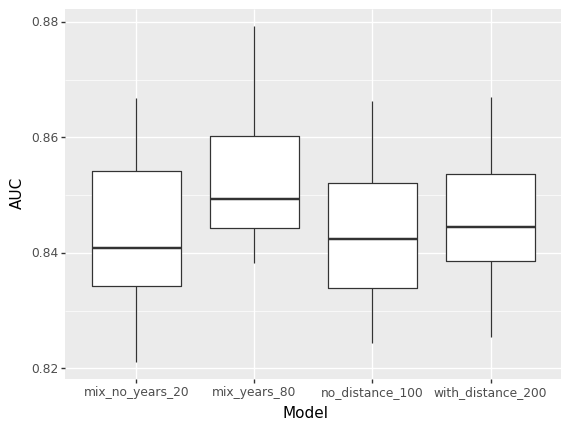

<ggplot: (8731465132937)>

In [ ]:
(AUC_df>>
 ggplot() +
 geom_boxplot(aes('Model','AUC',group='Model')) 
)

### Making a hard prediction using FCNN transition potential map

In [ ]:
# get the imgs from ee-asset
imgs = ! earthengine ls users/wangjinzhulala/GEE_TF/Urban_projection/
imgs = imgs[3:]

# get the target value of the transition potential map
for img in imgs:

  #___________________________ Find the target value to reclassify the transition potential map ___________________________

  # mosaic the imgs to a singble raster
  img_mosaic = ee.ImageCollection(img).mosaic().toInt16()

  # get the img name for reporting/exporting
  img_name = img.split('/')[-1]

  # get the pixel-count for each value
  pixel_count_info = img_mosaic.reduceRegion(reducer = ee.Reducer.frequencyHistogram(),
                    geometry = region.geometry().convexHull(),
                    scale = 30,
                    maxPixels = int(1e13),
                    tileScale = 1)
  
  # convert the pixel count to a df, then compute the cumulative value of pixel-count as the value "DESCENDED"
  pixel_count_dict = pixel_count_info.getInfo()['b1']
  pixel_count_df = pd.DataFrame([(int(k),int(v)) for k,v in pixel_count_dict.items() if (k != '0')&(k != 'null')])
  pixel_count_df.columns = ['val','count']
  pixel_count_df = pixel_count_df.sort_values('val', ignore_index=True, ascending=False)
  pixel_count_df['cum_sum'] = pixel_count_df['count'].cumsum()

  # compute the ratio of cum_sum/prj_count and the target value is the one that has the closete "diff_cum_to_prj" to 1
  pixel_count_df['diff_cum_to_prj'] = abs(pixel_count_df['cum_sum']/prj_count - 1)
  target_row = pixel_count_df[pixel_count_df['diff_cum_to_prj'] == pixel_count_df['diff_cum_to_prj'].min()]
  target_val = target_row['val'].values[0]
  target_error = target_row['diff_cum_to_prj'].values[0] * prj_count

  print(f'The target pixel value for {img_name} is {target_val} with {int(target_error)} un-match pixels')

  #___________________________ Make a hard classification using the target value ___________________________
  hard_classificatioin = img_mosaic.gte(int(target_val))

  # create the task
  task = ee.batch.Export.image.toAsset(
                      image = hard_classificatioin, 
                      description= f'Hard classification for {img_name}', 
                      assetId=f'users/wangjinzhulala/GEE_TF/Urban_projection/{img_name}_hard_classification', 
                      region=region.geometry().bounds(), 
                      scale=30, 
                      maxPixels=int(1e13)
    )

  # start the export
  task.start()

  # report the process
  print(f'Exporting {img_name}')
  print('----------------------------------------')

The target pixel value for FCNN_2011_2013_and_2014_2016_prj_2017_2019_mix_no_years_20 is 2085 with 18586 un-match pixels
The target pixel value for FCNN_2011_2013_and_2014_2016_prj_2017_2019_mix_years_80 is 1126 with 2118 un-match pixels
The target pixel value for FCNN_2011_2013_and_2014_2016_prj_2017_2019_no_distance_100 is 929 with 10996 un-match pixels
The target pixel value for FCNN_2011_2013_and_2014_2016_prj_2017_2019_with_distance_200 is 1303 with 4131 un-match pixels


### Calculate the accuracy metircs of hard predictions

In [ ]:
# get the hard predictions
hard_preds = ! earthengine ls users/wangjinzhulala/GEE_TF/Urban_projection/
hard_preds = [i for i in hard_preds[3:] if 'hard' in i]

In [ ]:
# mask the pred imgs, otherwise the pixels of out-research-region will be 
# included in the accuracy calculation 
hard_pred_imgs = [ee.Image(i).updateMask(mask) for i in hard_preds]

# get the img name and type
reg = re.compile(r'.*\d{4}_(.*_\d+).*')
hard_pred_names = [i.split('/')[-1] for i in hard_preds]
hard_pred_types = [reg.findall(i)[0] for i in hard_pred_names]

In [ ]:
# mutiply the true_pred_img by 10, then add it to hard_pred_img.
# so we can infer that pixel value of 11 mean the hard_pred is correct.
# similar to other values as 0(pred_0,true_0), 1(pred_0,true_1), 10(pred_1,true_0)
true_add_pred = [true_pred_img.multiply(10).add(img) for img in hard_pred_imgs]

In [ ]:
# get accuracy metrics 
acc_dict = {}

for pred_type,img in zip(hard_pred_types,true_add_pred):

  # get the statistics of true_add_pred
  true_pred_info = img.reduceRegion(reducer = ee.Reducer.frequencyHistogram(),
                    geometry = region.geometry().convexHull(),
                    scale = 30,
                    maxPixels = int(1e13),
                    tileScale = 1)
  
  # get the stats from GEE server
  stats = true_pred_info.getInfo()['b1']

  # compute the metrics
  tp,tn,fp,fn = stats['11'],stats['0'],stats['10'],stats['1']
  accuracy = (tp+tn)/sum([tp,tn,fp,fn]) * 100
  miscalssificaion = (fp+fn)/sum([tp,tn,fp,fn]) * 100
  precision = tp/(tp+fp) * 100
  recall = tp/(tp+fn) * 100
  specificity = tn/(tn+fp) * 100

  # put metrics to dict
  acc_dict[pred_type] = {'accuracy':accuracy,
              'miscalssificaion':miscalssificaion,
              'precision':precision,
              'recall':recall,
              'specificity':specificity}

  # report process
  print(f'{pred_type:<20} accuracy:{accuracy:.4f}\t precision:{precision:.4f}\t recall:{recall:.4f}\t specificity:{specificity:.4f}')

mix_no_years_20      accuracy:96.7380	 precision:88.1257	 recall:88.1363	 specificity:98.1082
mix_years_80         accuracy:96.8185	 precision:88.4229	 recall:88.4259	 specificity:98.1556
no_distance_100      accuracy:96.8695	 precision:88.6013	 recall:88.6167	 specificity:98.1840
with_distance_200    accuracy:96.8587	 precision:88.4045	 recall:88.6999	 specificity:98.1536


In [ ]:
pd.DataFrame(acc_dict).T.reset_index()

,index,accuracy,miscalssificaion,precision,recall,specificity
0,mix_no_years_20,96.737998,3.262002,88.125707,88.136253,98.108232
1,mix_years_80,96.818510,3.181490,88.422936,88.425917,98.155560
2,no_distance_100,96.869452,3.130548,88.601274,88.616677,98.184013
3,with_distance_200,96.858744,3.141256,88.404492,88.699891,98.153591


In [ ]:
# ########## Using gdal will exceed the memory  #################

# # set the working directory
# % cd '/content/G_drive/MyDrive/Colab Notebooks/FCNN_urban_projection/Step_2_Calculate_frequency_of_factors'

# # get all tif files
# img_on_disk = !ls /content/G_drive/MyDrive/urban_projection_result_imgs/*

# # get the single img name, because the imgs may be splited into shareds
# img_single_name = set([i.split('-')[0] for i in img_on_disk])

# # get the target value of the transition potential map
# for img in img_single_name:

#   img_name = img.split('/')[-1]

#   # get the img shards using single img name
#   img_shards = ! ls {img}*
#   img_rel_path = [os.path.relpath(i) for i in img_shards]

#   # mosaic all shards into one img using gdal.BuildVRT
#   vrt = gdal.BuildVRT('./mosaic.vrt',img_rel_path)
#   mosaic_img_arr = vrt.GetRasterBand(1).ReadAsArray()


#   #_____________________________________ Get the target pixel value from the transition potential map ___________________________________
#   # get the pixel-count tuple
#   pixel_val,pixel_count = np.unique(mosaic_img_arr,return_counts=True)
#   pixel_count = list(zip(pixel_val,pixel_count))[::-1]

#   # convert pixel-count tuple to df, then compute the cumulative number with descending pixel value
#   df_cum = pd.DataFrame(pixel_count)
#   df_cum.columns = ['val','count']
#   df_cum['cum_sum'] = df_cum['count'].cumsum()

#   # compute the ratio of cum_sum/prj_count and the target value is the one that has the closete "diff_cum_to_prj" to 1
#   df_cum['diff_cum_to_prj'] = abs(df_cum['cum_sum']/prj_count - 1)
#   target_row = df_cum[df_cum['diff_cum_to_prj'] == df_cum['diff_cum_to_prj'].min()]
#   target_val = target_row['val'].values[0]
#   target_error = target_row['diff_cum_to_prj'].values[0] * prj_count

#   # get the target img-array
#   target_arr = mosaic_img_arr>=target_val

#   #________________________________________________ Save the predicted tif back to dist _________________________________________________
#   driver = gdal.GetDriverByName('GTiff')
#   out_ds = driver.Create(f'/content/G_drive/MyDrive/urban_projection_result_imgs/{img_name}.tif',
#               xsize = vrt.RasterXSize,
#               ysize = vrt.RasterYSize,
#               bands = 1,
#               eType = gdal.GDT_Int16)

#   out_ds.SetGeoTransform(vrt.GetGeoTransform())
#   out_ds.SetProjection(vrt.GetProjection())

#   out_band = out_ds.GetRasterBand(1)
#   out_band.WriteArray(target_arr)

#   out_ds = out_band = None